# Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning

## Conversion Rate Analysis Based on Income, Spending and Age

### Initialization

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

sns.set(rc={'figure.figsize':(16,8)})
plt.style.use("fivethirtyeight")
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Retrieve Dataset

In [3]:
dataset = pd.read_csv('C:/Users/62812/Downloads/marketing_campaign_data.csv', sep=',')
dataset.tail()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2235,2235,10870,1967,S1,Menikah,61223000.0,0,1,13-06-2013,46,...,5,0,0,0,0,0,0,3,11,0
2236,2236,4001,1946,S3,Bertunangan,64014000.0,2,1,10-06-2014,56,...,7,0,0,0,1,0,0,3,11,0
2237,2237,7270,1981,S1,Cerai,56981000.0,0,0,25-01-2014,91,...,6,0,1,0,0,0,0,3,11,0
2238,2238,8235,1956,S2,Bertunangan,69245000.0,0,1,24-01-2014,8,...,3,0,0,0,0,0,0,3,11,0
2239,2239,9405,1954,S3,Menikah,52869000.0,1,1,15-10-2012,40,...,7,0,0,0,0,0,0,3,11,1


### Features

In [4]:
dataset.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

### Feature Engineering

In [5]:
import numpy as np
dataset['Dt_Customer'] = pd.to_datetime(dataset['Dt_Customer'])

dataset['age'] = 2022 - dataset['Year_Birth']
dataset['join_at_age'] = dataset['Dt_Customer'].dt.year - dataset['Year_Birth']
dataset['total_kids'] = dataset['Kidhome'] + dataset['Teenhome']
dataset['is_parents'] = np.where(dataset['total_kids'] > 0, 1, 0)

# age_range
dataset.loc[(dataset['age'] >= 0) & (dataset['age'] < 12), 'age_range'] = "child"
dataset.loc[(dataset['age'] >= 12) & (dataset['age'] < 18), 'age_range'] = "teens"
dataset.loc[(dataset['age'] >= 18) & (dataset['age'] < 36), 'age_range'] = "young_adults"
dataset.loc[(dataset['age'] >= 36) & (dataset['age'] < 55), 'age_range'] = "middle_aged_adults"
dataset.loc[(dataset['age'] >= 55), 'age_range'] = "older_adults"

# amount spent
dataset['total_amount_spent'] = dataset['MntCoke'] \
                              + dataset['MntFruits'] \
                              + dataset['MntMeatProducts'] \
                              + dataset['MntFishProducts'] \
                              + dataset['MntSweetProducts'] \
                              + dataset['MntGoldProds']

# accepted campaigns
dataset['total_accepted_campaign'] = dataset['AcceptedCmp1'] \
                                    + dataset['AcceptedCmp2'] \
                                    + dataset['AcceptedCmp3'] \
                                    + dataset['AcceptedCmp4'] \
                                    + dataset['AcceptedCmp5']

# total transaction purchased --- WE ASSUMED ALL OF THIS PURCHASES ARE MECE (mutually exclusive and collectively exhaustive)
dataset['total_transaction'] = dataset['NumDealsPurchases'] \
                            + dataset['NumWebPurchases'] \
                            + dataset['NumCatalogPurchases'] \
                            + dataset['NumStorePurchases']

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

dataset['cvr'] = dataset.apply(lambda x: safe_div(x['total_transaction'],x['NumWebVisitsMonth']), axis=1)

### Statistical Summaries

In [6]:
numerical_features = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke', 
                      'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                      'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue',
                      'age', 'join_at_age', 'total_kids', 'total_amount_spent'
                     ]

categorical_features = ['Education', 'Marital_Status',
                        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                        'AcceptedCmp4', 'AcceptedCmp5', 'Complain',
                        'Response', 'is_parents', 'age_range'
                       ]

In [7]:
dataset[numerical_features].describe()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,age,join_at_age,total_kids,total_amount_spent
count,2.216000e+03,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000,2240.000000,2240.000000,2.240000e+03
mean,5.224725e+07,0.444196,0.506250,49.109375,3.039357e+05,26302.232143,1.669500e+05,37525.446429,27062.946429,44021.875000,...,4.084821,2.662054,5.790179,5.316518,3.0,11.0,53.194196,44.222321,0.950446,6.057982e+05
std,2.517308e+07,0.538398,0.544538,28.962453,3.365974e+05,39773.433765,2.257154e+05,54628.979403,41280.498488,52167.438915,...,2.778714,2.923101,3.250958,2.426645,0.0,0.0,11.984069,12.022855,0.751803,6.022493e+05
min,1.730000e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.0,11.0,26.000000,16.000000,0.000000,5.000000e+03
25%,3.530300e+07,0.000000,0.000000,24.000000,2.375000e+04,1000.000000,1.600000e+04,3000.000000,1000.000000,9000.000000,...,2.000000,0.000000,3.000000,3.000000,3.0,11.0,45.000000,36.000000,0.000000,6.875000e+04
50%,5.138150e+07,0.000000,0.000000,49.000000,1.735000e+05,8000.000000,6.700000e+04,12000.000000,8000.000000,24000.000000,...,4.000000,2.000000,5.000000,6.000000,3.0,11.0,52.000000,43.000000,1.000000,3.960000e+05
75%,6.852200e+07,1.000000,1.000000,74.000000,5.042500e+05,33000.000000,2.320000e+05,50000.000000,33000.000000,56000.000000,...,6.000000,4.000000,8.000000,7.000000,3.0,11.0,63.000000,54.000000,1.000000,1.045500e+06
max,6.666660e+08,2.000000,2.000000,99.000000,1.493000e+06,199000.000000,1.725000e+06,259000.000000,263000.000000,362000.000000,...,27.000000,28.000000,13.000000,20.000000,3.0,11.0,129.000000,121.000000,3.000000,2.525000e+06


In [8]:
dataset[categorical_features].describe()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,is_parents
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,0.064286,0.013393,0.072768,0.074554,0.072768,0.009375,0.149107,0.715179
std,0.245316,0.114976,0.259813,0.262728,0.259813,0.096391,0.356274,0.451430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Bivariate Analysis

#### Correlation Plot

<AxesSubplot:>

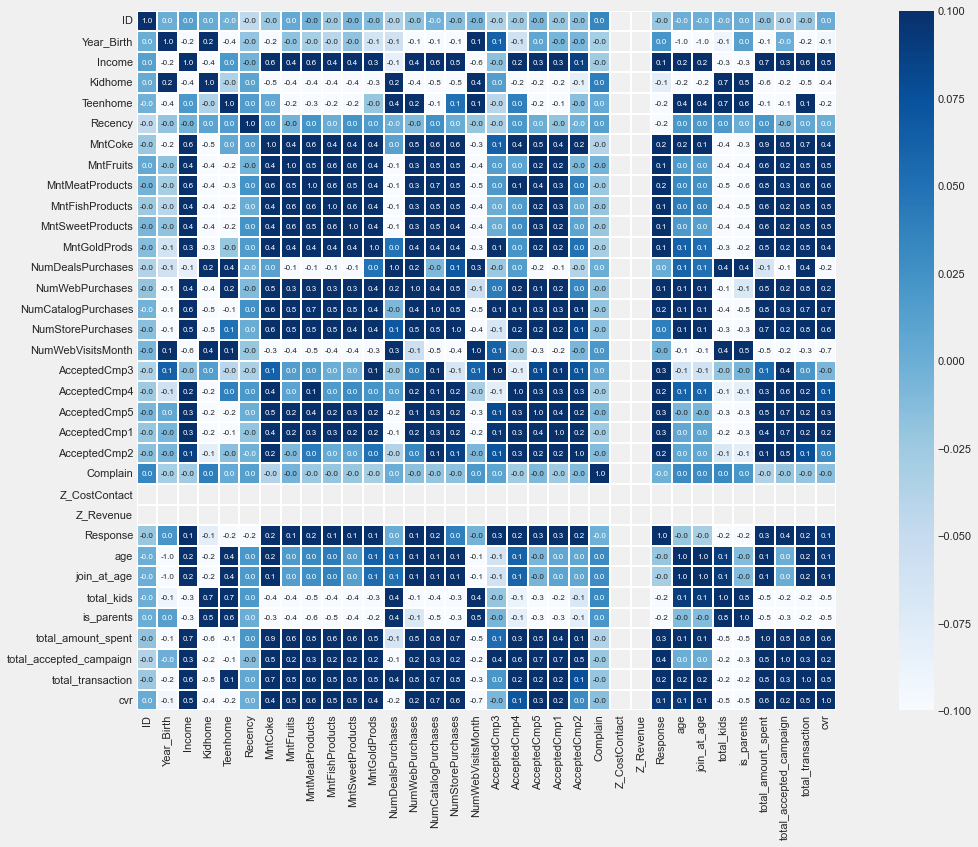

In [9]:
dataset=dataset.drop(['Unnamed: 0'], axis=1)
# correlation heatmap
plt.figure(figsize=(20, 12))
corrmat = dataset.corr()
sns.heatmap(corrmat, cmap='Blues', annot=True, fmt='.1f',
           vmin=corrmat.values.min(), vmax=1, square=True, linewidths=0.1, annot_kws={"fontsize":8})

#### Income vs Spending

(0.0, 120000000.0)

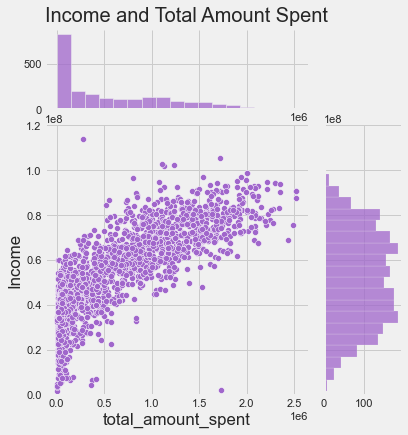

In [10]:
plot2 = sns.jointplot(data=dataset, x="total_amount_spent", y="Income", color='#A066CB', height=6, ratio=3, marginal_ticks=True)
plt.text(x=-700, y=166000000, s="Income and Total Amount Spent", fontsize=20)
plot2.ax_marg_y.set_ylim(0, 120000000)

(0.0, 120000000.0)

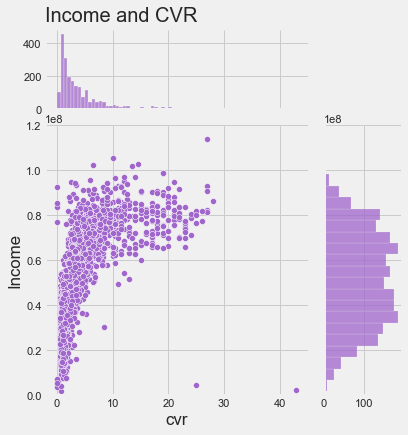

In [11]:
plot2 = sns.jointplot(data=dataset, x="cvr", y="Income", color='#A066CB', height=6, ratio=3, marginal_ticks=True)
plt.text(x=-700, y=166000000, s="Income and CVR", fontsize=20)
plot2.ax_marg_y.set_ylim(0, 120000000)

(0.0, 80.0)

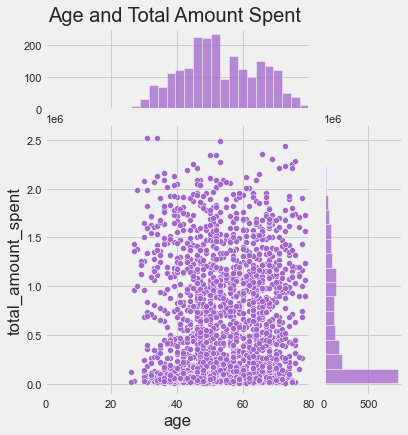

In [12]:
plot2 = sns.jointplot(data=dataset, x="age", y="total_amount_spent", height=6, ratio=3, color='#A066CB', marginal_ticks=True)
plt.text(x=-3100, y=3720000, s="Age and Total Amount Spent", fontsize=20)
plot2.ax_marg_x.set_xlim(0, 80)

#### Age vs Spending & Income

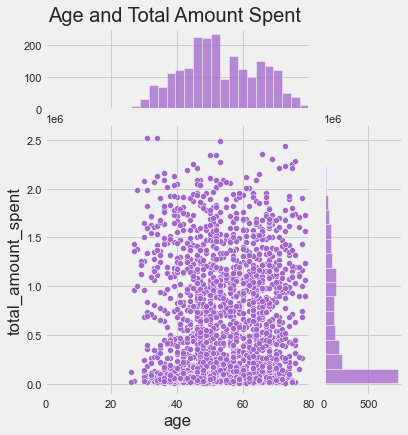

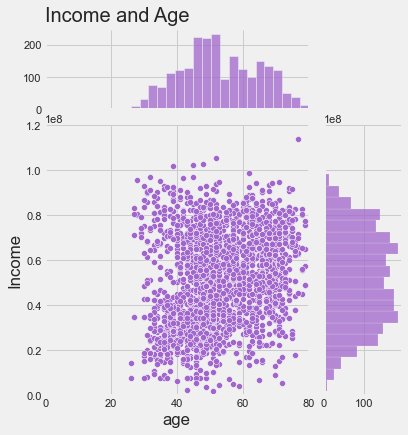

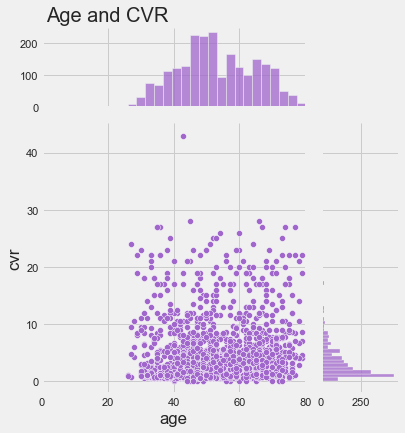

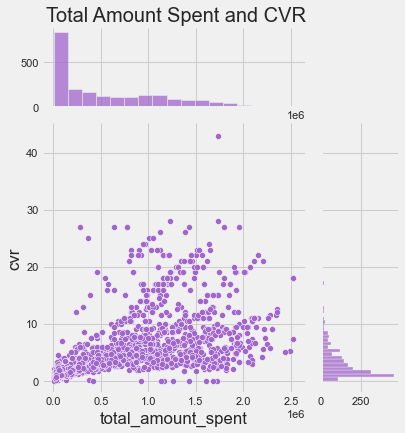

In [13]:
plot2 = sns.jointplot(data=dataset, x="age", y="total_amount_spent", height=6, ratio=3, color='#A066CB', marginal_ticks=True)
plt.text(x=-3100, y=3720000, s="Age and Total Amount Spent", fontsize=20)
plot2.ax_marg_x.set_xlim(0, 80)
plt.show()

plot2 = sns.jointplot(data=dataset, x="age", y="Income", color='#A066CB', height=6, ratio=3, marginal_ticks=True)
plt.text(x=-700, y=166000000, s="Income and Age", fontsize=20)
plot2.ax_marg_x.set_xlim(0, 80)
plot2.ax_marg_y.set_ylim(0, 120000000)
plt.show()

plot2 = sns.jointplot(data=dataset, x="age", y="cvr", color='#A066CB', height=6, ratio=3, marginal_ticks=True)
plt.text(x=-1700, y=63, s="Age and CVR", fontsize=20)
plot2.ax_marg_x.set_xlim(0, 80)
plt.show()

plot2 = sns.jointplot(data=dataset, x="total_amount_spent", y="cvr", color='#A066CB', height=6, ratio=3, marginal_ticks=True)
plt.text(x=-1700, y=63, s="Total Amount Spent and CVR", fontsize=20)
plt.show()

## Data Cleaning and Preprocessing

In [12]:
dataset.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age', 'join_at_age', 'total_kids', 'is_parents', 'age_range',
       'total_amount_spent', 'total_accepted_campaign', 'total_transaction',
       'cvr'],
      dtype='object')

### Null Values

In [13]:
dataset.isna().sum()

ID                          0
Year_Birth                  0
Education                   0
Marital_Status              0
Income                     24
Kidhome                     0
Teenhome                    0
Dt_Customer                 0
Recency                     0
MntCoke                     0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Z_CostContact               0
Z_Revenue                   0
Response                    0
age                         0
join_at_age                 0
total_kids                  0
is_parents                  0
age_range 

We have null values in Income column, with 24 rows (1.07% of data). since the number is quite low, we just can remove this safely

In [14]:
dataset = dataset.dropna()

### Duplicate Rows

In [15]:
dataset.duplicated().sum()

0

In [16]:
dataset.shape

(2216, 38)

We have no duplicate data here

### Feature Encoding

In [17]:
for col in categorical_features:
    print(f'value counts of column {col}')
    print(dataset[col].value_counts())
    print('---'*10, '\n')

value counts of column Education
S1     1116
S3      481
S2      365
D3      200
SMA      54
Name: Education, dtype: int64
------------------------------ 

value counts of column Marital_Status
Menikah        857
Bertunangan    573
Lajang         475
Cerai          232
Janda           76
Duda             3
Name: Marital_Status, dtype: int64
------------------------------ 

value counts of column AcceptedCmp1
0    2074
1     142
Name: AcceptedCmp1, dtype: int64
------------------------------ 

value counts of column AcceptedCmp2
0    2186
1      30
Name: AcceptedCmp2, dtype: int64
------------------------------ 

value counts of column AcceptedCmp3
0    2053
1     163
Name: AcceptedCmp3, dtype: int64
------------------------------ 

value counts of column AcceptedCmp4
0    2052
1     164
Name: AcceptedCmp4, dtype: int64
------------------------------ 

value counts of column AcceptedCmp5
0    2054
1     162
Name: AcceptedCmp5, dtype: int64
------------------------------ 

value counts o

In [18]:
# label encoder
mapping_education = {
    'SMA' : 0,
    'D3' : 1,
    'S1' : 2,
    'S2' : 3,
    'S3' : 4
}

dataset['Education_mapped'] = dataset['Education'].map(mapping_education)

In [19]:
dataset_cats = dataset[['Education']].copy()
# One hot encoder
for cat in ['Marital_Status', 'age_range', 'is_parents']:
    onehots = pd.get_dummies(dataset[cat], prefix=cat)
    dataset_cats = dataset_cats.join(onehots)

### Feature Standardization

In [20]:
from sklearn.preprocessing import StandardScaler
dataset_scaled = dataset.copy()
ss = StandardScaler()

for col in numerical_features:
    dataset_scaled[col] = ss.fit_transform(dataset_scaled[[col]])
    
display(dataset_scaled.shape, dataset_scaled.head(3))

(2216, 39)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,age,join_at_age,total_kids,is_parents,age_range,total_amount_spent,total_accepted_campaign,total_transaction,cvr,Education_mapped
0,5524,1957,S1,Lajang,0.234063,-0.823039,-0.928972,2012-04-09,0.310532,0.978226,...,0.986443,0.897752,-1.264803,0,older_adults,1.675488,0,25,3.571429,2
1,2174,1954,S1,Lajang,-0.234559,1.039938,0.909066,2014-08-03,-0.380509,-0.872024,...,1.236801,1.313688,1.405806,1,older_adults,-0.962358,0,6,1.200000,2
2,4141,1965,S1,Bertunangan,0.769478,-0.823039,-0.928972,2013-08-21,-0.795134,0.358511,...,0.318822,0.315443,-1.264803,0,older_adults,0.280250,0,21,5.250000,2


In [21]:
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,age,join_at_age,total_kids,is_parents,age_range,total_amount_spent,total_accepted_campaign,total_transaction,cvr,Education_mapped
0,5524,1957,S1,Lajang,58138000.0,0,0,2012-04-09,58,635000,...,65,55,0,0,older_adults,1617000,0,25,3.571429,2
1,2174,1954,S1,Lajang,46344000.0,1,1,2014-08-03,38,11000,...,68,60,2,1,older_adults,27000,0,6,1.200000,2
2,4141,1965,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,426000,...,57,48,0,0,older_adults,776000,0,21,5.250000,2
3,6182,1984,S1,Bertunangan,26646000.0,1,0,2014-10-02,26,11000,...,38,30,1,1,middle_aged_adults,53000,0,8,1.333333,2
4,5324,1981,S3,Menikah,58293000.0,1,0,2014-01-19,94,173000,...,41,33,1,1,middle_aged_adults,422000,0,19,3.800000,4


## Data Modeling : K-means clustering

[104357.21965506385, 77987.73445441764, 61652.368365831375, 55343.15638363004, 50312.12964007022, 46904.7008946435, 43896.02029590343, 41424.98383228292, 40017.362973949734, 38809.052677002976, 37629.417075887584, 36804.63151040458, 35881.145593858746, 35182.2190683029, 34450.10520404354, 33813.88775651708, 33257.33901476106, 32662.890141160482]


Text(0, 0.5, 'Distortion')

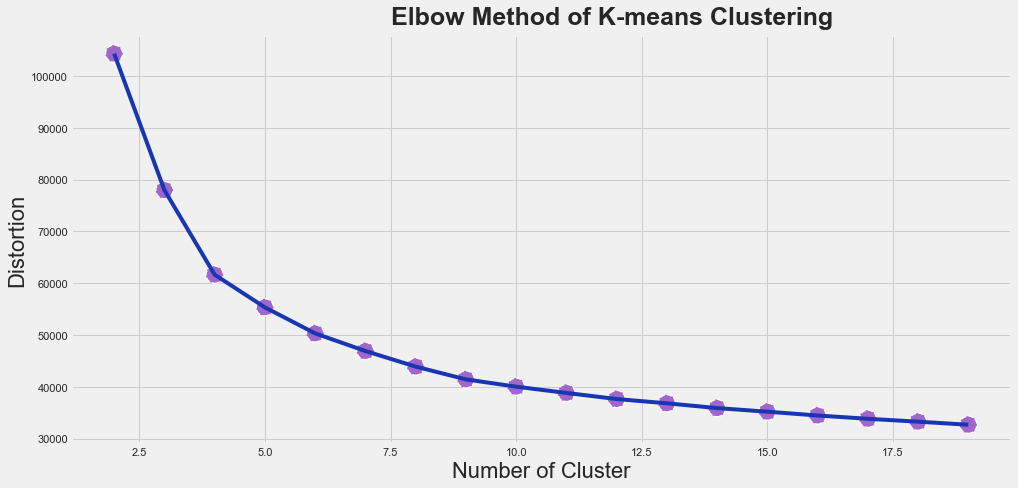

In [22]:
from sklearn.cluster import KMeans
X = dataset_scaled.drop(columns=['ID', 'Year_Birth', 'Education', 'Marital_Status', 'age_range', 'Dt_Customer']).copy()
# X = dataset_scaled[numerical_features].copy()
inertia = []

for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X.values)
    inertia.append(kmeans.inertia_)

print(inertia)
plt.figure(figsize=(15, 7))
plt.text(x=7.5, y=110000, s="Elbow Method of K-means Clustering", fontsize=25, fontweight='bold')
# plt.plot(inertia)

sns.lineplot(x=range(2, 20), y=inertia, color='#1836B2', linewidth = 4)
sns.scatterplot(x=range(2, 20), y=inertia, s=300, color='#A066CB', linestyle='--')
plt.xlabel('Number of Cluster', fontsize=22) 
plt.ylabel('Distortion', fontsize=22)

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X.values)
X['cluster'] = kmeans.labels_
dataset['cluster'] = kmeans.labels_

In [24]:
X.tail()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,age,join_at_age,total_kids,is_parents,total_amount_spent,total_accepted_campaign,total_transaction,cvr,Education_mapped,cluster
2235,0.356642,-0.823039,0.909066,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,3.919308,...,0.151917,0.149069,0.070501,1,1.217598,0,18,3.600000,2,0
2236,0.467539,2.902916,0.909066,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,-0.694260,...,1.904422,1.979184,2.741110,1,-0.270546,1,22,3.142857,4,2
2237,0.188091,-0.823039,-0.928972,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,-0.385402,...,-1.016420,-0.932363,-1.264803,0,1.051696,1,19,3.166667,2,0
2238,0.675388,-0.823039,0.909066,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,0.328832,...,1.069896,1.147313,0.070501,1,0.391404,0,23,7.666667,3,2
2239,0.024705,1.039938,0.909066,-0.311405,-0.655568,-0.587058,-0.472705,-0.651038,-0.633880,-0.443313,...,1.236801,1.147313,1.405806,1,-0.721800,0,11,1.571429,4,1


<AxesSubplot:xlabel='total_amount_spent', ylabel='Income'>

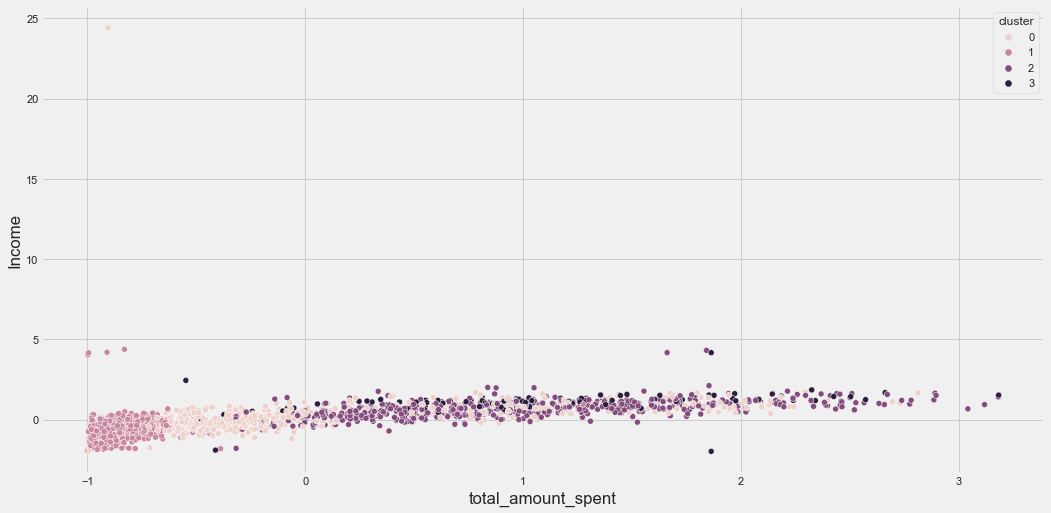

In [25]:
sns.scatterplot(data=X, x='total_amount_spent', y='Income', hue='cluster')

### Eval: Silhouette Score

In [26]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure(figsize=(15, 7))
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap="Spectral")
    plt.tight_layout()
    plt.text(x=0.25, y=-0.2, s="Silhouette Score of K-means Clustering", fontsize=20, fontweight='bold')
    plt.show()

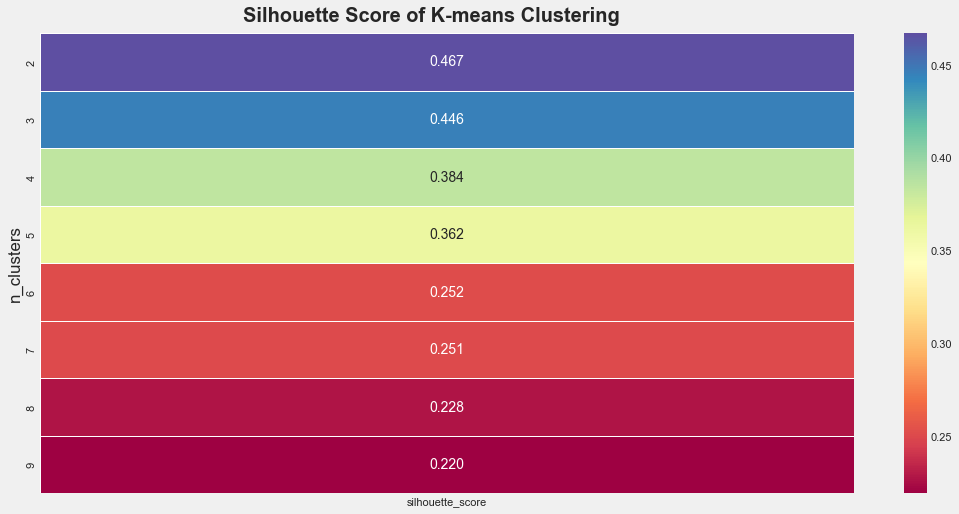

In [27]:
visualize_silhouette_layer(X)

## Customer personality analysis for marketing retargeting

### Statistical Summary per Cluster

In [28]:
numerical_features

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntCoke',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Z_CostContact',
 'Z_Revenue',
 'age',
 'join_at_age',
 'total_kids',
 'total_amount_spent']

In [29]:
dataset[numerical_features+['cluster']].groupby('cluster')['Income','total_amount_spent'].describe()

Income                                                                 \
         count          mean           std        min         25%         50%   
cluster                                                                         
0        600.0  5.915598e+07  2.907067e+07  1730000.0  47159000.0  57313000.0   
1        915.0  3.376977e+07  1.430822e+07  3502000.0  24736500.0  33402000.0   
2        564.0  6.846531e+07  1.320797e+07  7144000.0  60407500.0  68117500.0   
3        137.0  7.863174e+07  1.416946e+07  2447000.0  72679000.0  80124000.0   

                                 total_amount_spent                \
                75%          max              count          mean   
cluster                                                             
0        68722500.0  666666000.0              600.0  7.172950e+05   
1        41020500.0  162397000.0              915.0  7.612787e+04   
2        76738500.0  160803000.0              564.0  1.185512e+06   
3        83829000.0  157146000.0              137.0  1.289168e+06   

                                                                             
                   std       min       25%        50%        75%        max  
cluster                                                                      
0        493792.719730    8000.0  346000.0   506000.0  1035250.0  2302000.0  
1         71647.141976    5000.0   36000.0    57000.0    96000.0  1376000.0  
2        444518.680991  415000.0  833500.0  1110500.0  1486250.0  2524000.0  
3        432624.303275  277000.0  988000.0  1216000.0  1574000.0  2525000.0

In [30]:
map_cluster = {
    0 : 'Low Spender',
    1 : 'Risk of Churn',
    2 : 'Mid Spender',
    3 : 'High Spender'
}

dataset['Cluster Mapped'] = dataset['cluster'].map(map_cluster)

Text(0.5, 980, 'Users per Cluster')

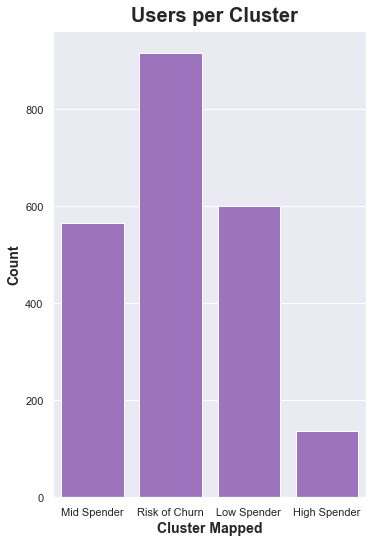

In [31]:
sns.set(rc={'figure.figsize':(5,8)})
sns.countplot(x=dataset['Cluster Mapped'], color='#A066CB')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Mapped', fontsize=14, fontweight='bold')
plt.text(x=0.5, y=980, s="Users per Cluster", fontsize=20, fontweight='bold')

(0.0, 120000000.0)

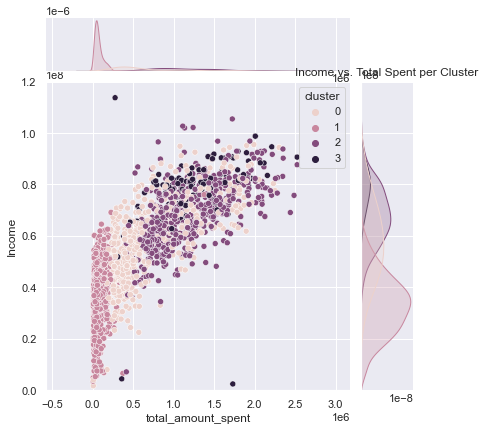

In [32]:
plot = sns.jointplot(x=dataset["total_amount_spent"], y=dataset["Income"], hue=dataset["cluster"])
plt.title('Income vs. Total Spent per Cluster')
plot.ax_marg_y.set_ylim(0, 120000000)

### Total Income per Cluster

Text(0.75, 123000000, 'Annual Income for Each Cluster')

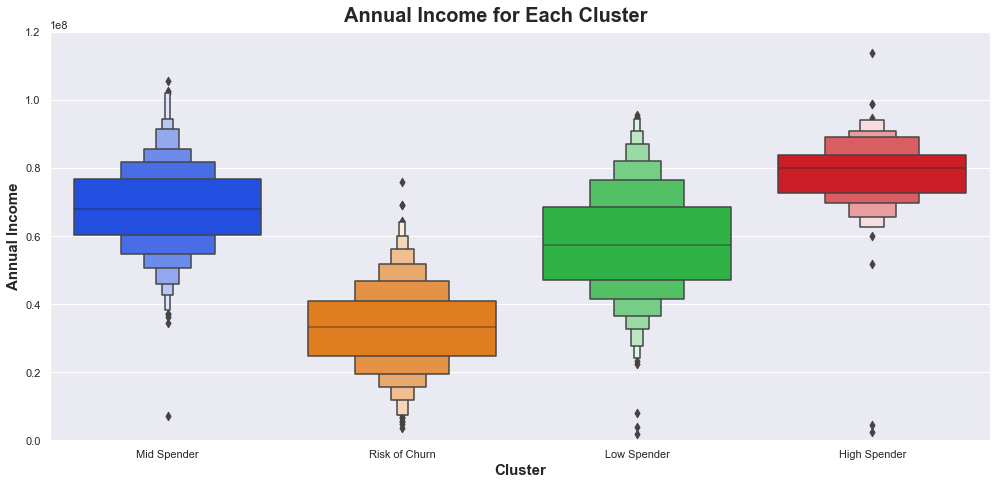

In [33]:
plt.figure(figsize=(15, 7))
sns.boxenplot(x=dataset['Cluster Mapped'], y=dataset['Income'], palette='bright')
plt.ylim(0, 120000000)
plt.ylabel('Annual Income', fontsize=15, fontweight='bold')
plt.xlabel('Cluster', fontsize=15, fontweight='bold')
plt.text(x=0.75, y=123000000, s="Annual Income for Each Cluster", fontsize=20, fontweight='bold')

### Total Spending per Cluster

Text(0.7, 2730000, 'Annual Expenditure for Each Cluster')

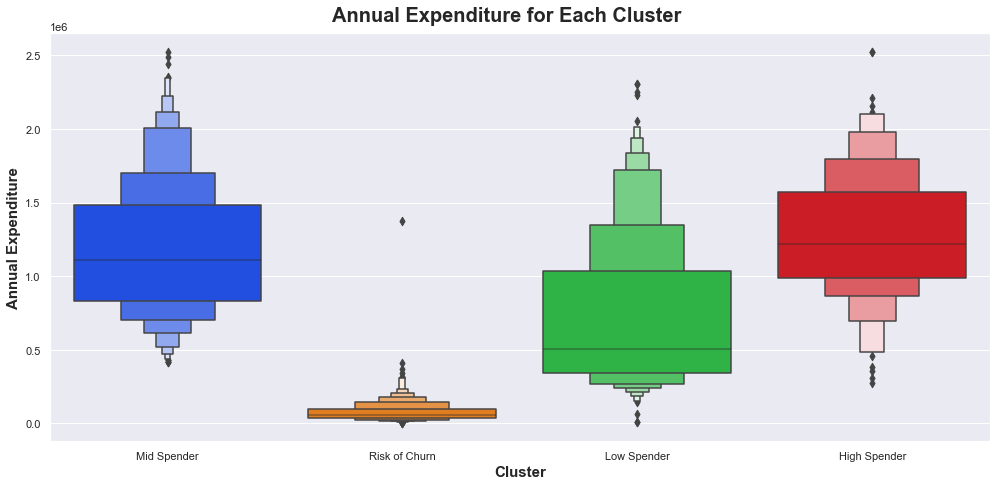

In [34]:
plt.figure(figsize=(15, 7))
sns.boxenplot(x=dataset['Cluster Mapped'], y=dataset['total_amount_spent'], palette='bright')
plt.ylabel('Annual Expenditure', fontsize=15, fontweight='bold')
plt.xlabel('Cluster', fontsize=15, fontweight='bold')
plt.text(x=0.7, y=2730000, s="Annual Expenditure for Each Cluster", fontsize=20, fontweight='bold')

Cluster 1 and 2 spent the highest respectively

### Total Visits per Cluster

Text(0.7, 21.5, 'Web Visits per Month for Each Cluster')

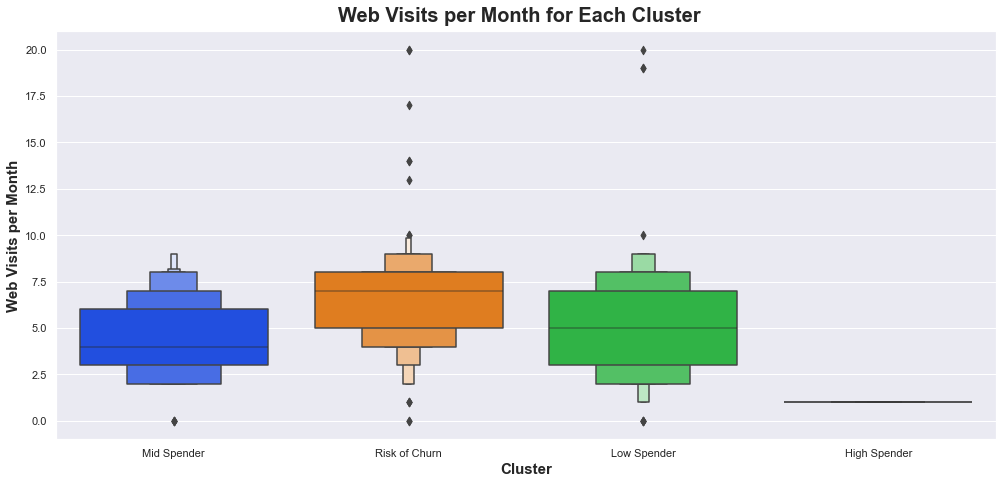

In [35]:
plt.figure(figsize=(15, 7))
sns.boxenplot(x=dataset['Cluster Mapped'], y=dataset['NumWebVisitsMonth'], palette='bright')
plt.ylabel('Web Visits per Month', fontsize=15, fontweight='bold')
plt.xlabel('Cluster', fontsize=15, fontweight='bold')
plt.text(x=0.7, y=21.5, s="Web Visits per Month for Each Cluster", fontsize=20, fontweight='bold')

### Deal Puchased per Cluster

Text(0.5, 16.3, 'Number of Purchase Transactions per Cluster')

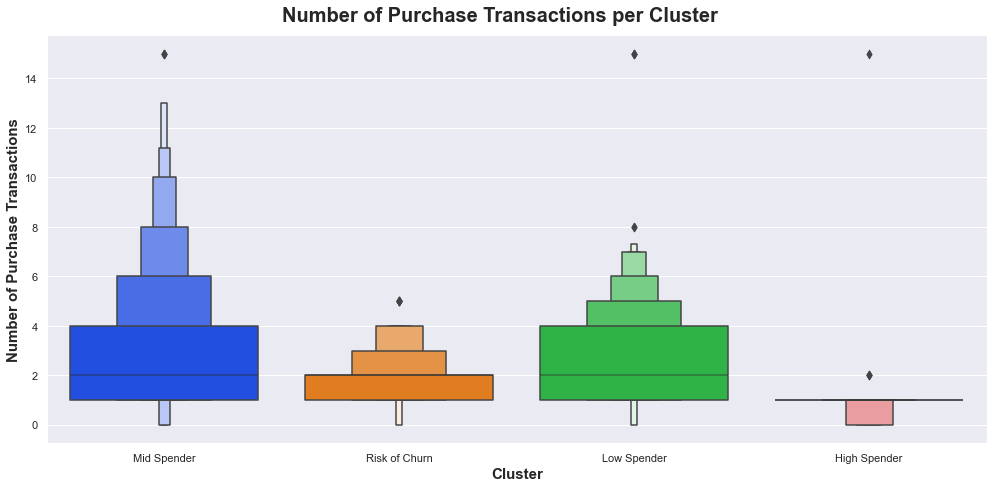

In [36]:
plt.figure(figsize=(15, 7))
sns.boxenplot(x=dataset['Cluster Mapped'], y=dataset['NumDealsPurchases'], palette='bright')
plt.ylabel('Number of Purchase Transactions', fontsize=15, fontweight='bold')
plt.xlabel('Cluster', fontsize=15, fontweight='bold')
plt.text(x=0.5, y=16.3, s="Number of Purchase Transactions per Cluster", fontsize=20, fontweight='bold')

### Conversion per Cluster

Text(0.75, 46, 'Conversion Rate per Cluster')

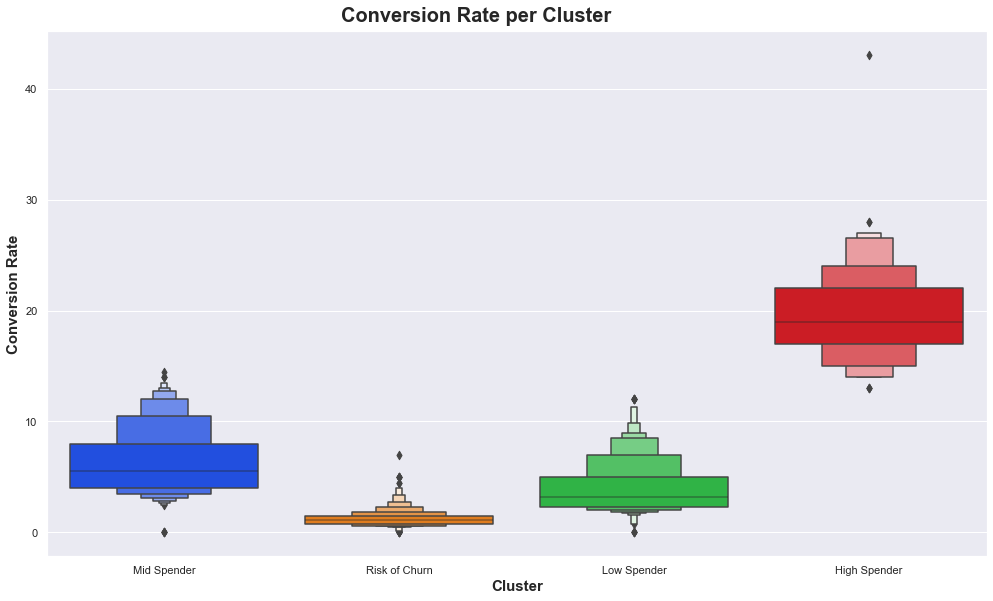

In [46]:
plt.figure(figsize=(15, 9))
sns.boxenplot(x=dataset['Cluster Mapped'], y=dataset['cvr'], palette='bright')
plt.ylabel('Conversion Rate', fontsize=15, fontweight='bold')
plt.xlabel('Cluster', fontsize=15, fontweight='bold')
plt.text(x=0.75, y=46, s="Conversion Rate per Cluster", fontsize=20, fontweight='bold')